In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [53]:
match = pd.read_csv('/content/matches.csv')
delivery = pd.read_csv('/content/deliveries.csv')
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [54]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [55]:
total_score_df = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')

In [56]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [57]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [58]:
match_df = match_df[match_df['dl_applied'] == 0]

In [59]:
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [68]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball'])
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: 0 if x == "0" else 1)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype(int)
delivery_df['wickets'] = 10 - delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']
delivery_df.replace([np.inf, -np.inf], np.nan, inplace=True)
delivery_df.dropna(subset=['crr', 'rrr'], inplace=True)

In [70]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result, axis=1)
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]
final_df = final_df.sample(final_df.shape[0])
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]

In [71]:
X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [72]:
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse=False, drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

In [73]:
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
])

pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [74]:
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.81%


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6693
           1       0.81      0.81      0.81      7576

    accuracy                           0.80     14269
   macro avg       0.80      0.80      0.80     14269
weighted avg       0.80      0.80      0.80     14269



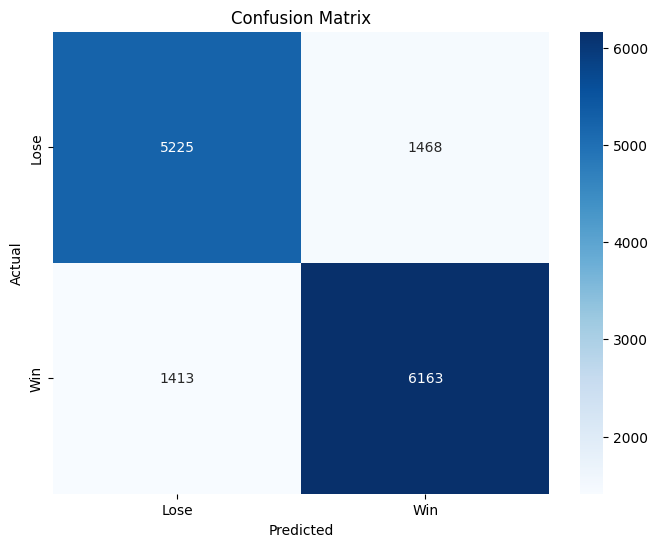

In [76]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Lose', 'Win'], yticklabels=['Lose', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Target- 178


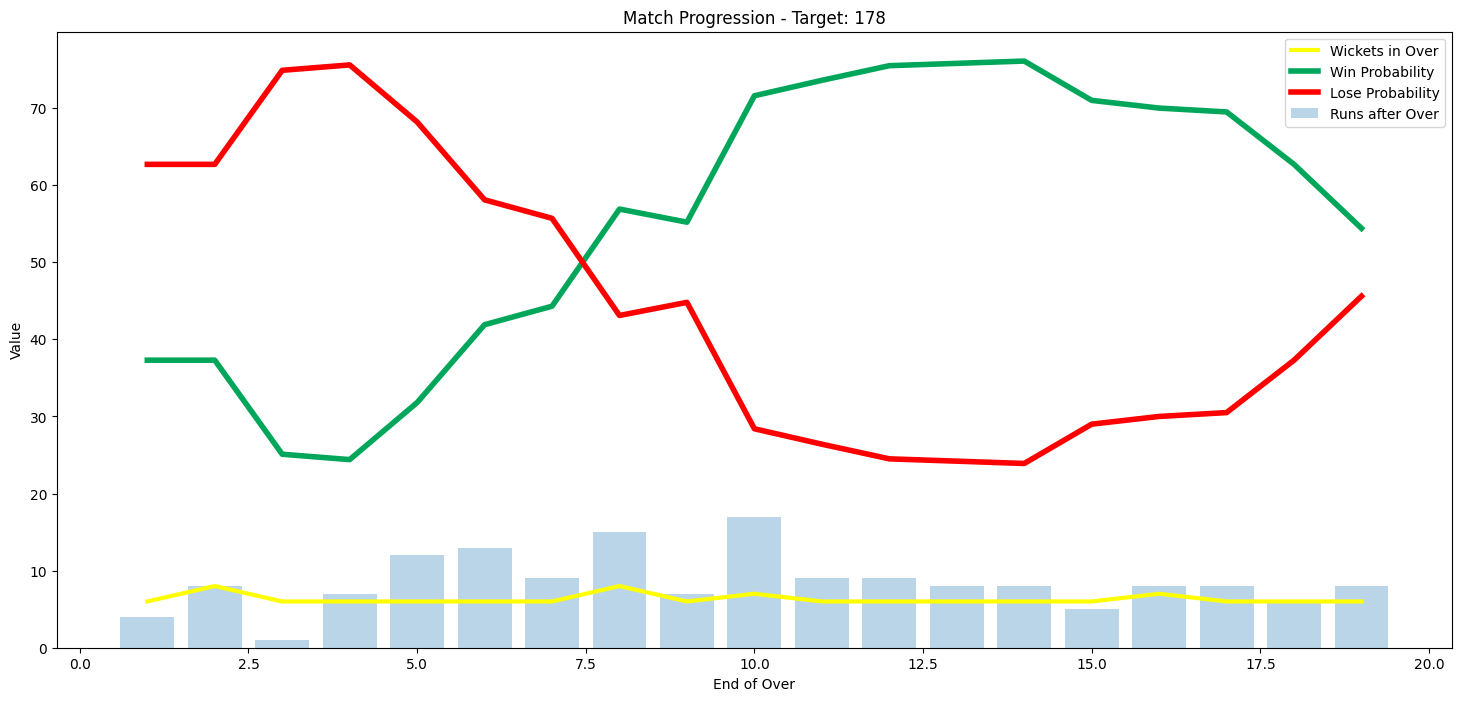

In [77]:
def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target

# Visualize a specific match progression
temp_df, target = match_progression(delivery_df, 74, pipe)

plt.figure(figsize=(18, 8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3, label='Wickets in Over')
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4, label='Win Probability')
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4, label='Lose Probability')
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'], alpha=0.3, label='Runs after Over')
plt.title('Match Progression - Target: ' + str(target))
plt.xlabel('End of Over')
plt.ylabel('Value')
plt.legend()
plt.show()